# Install Qiskit ignis

In [1]:
!git clone https://github.com/Qiskit/qiskit-ignis.git

fatal: destination path 'qiskit-ignis' already exists and is not an empty directory.


In [1]:
!pip install -e qiskit-ignis

Obtaining file:///Users/mamico/qiskit-ignis
  Found existing installation: qiskit-ignis 0.1.0
    Uninstalling qiskit-ignis-0.1.0:
      Successfully uninstalled qiskit-ignis-0.1.0
  Running setup.py develop for qiskit-ignis
You are using pip version 19.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Imports

In [13]:
import sys
sys.path.append('qiskit-ignis/qiskit')
import numpy as np
import time
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, BasicAer
from qiskit.quantum_info import state_fidelity
import qiskit.ignis.verification.tomography as tomo
from qiskit.tools.visualization import plot_state_city
import matplotlib.pyplot as plt
from qiskit.providers.aer import noise # import AER noise model
from qiskit.ignis.mitigation.measurement import *
from IPython.display import display
import qutip as qt
import qinfer as qi
from qinfer import LiuWestResampler

# Functions for Bayesian tomography

In [14]:
def bme_fit(probs, basis_matrix, shots):

    N = int(np.sqrt(basis_matrix[0].shape[0]))
    SAMPLES = 400

    def logl(rho, meas_res):

        logl = 0.0
        for result in meas_res:
            logl += result[1] * np.log(np.real(np.trace(np.matmul(np.reshape(result[0], (N,N)), rho))))

        return logl

    def montecarlo(N, likelihood, nsamples):
        result = np.zeros((N, N), dtype='complex')
        error = np.kron(result, result)

        # Estimated density operator
        for i in range(nsamples):
            rho = ginibre(N)
            L = np.exp(likelihood(rho))
            result += L * rho
            error += L * np.kron(rho, rho)

        result /= nsamples
        trace = np.trace(result)
        result /= trace

        error /= nsamples
        error /= trace
        error -= np.kron(result, result)

        return result, error


    # print(basis_matrix)
    # print(probs)

    counts = [i * shots for i in probs]

    # print(counts)

    meas_res = list(zip(basis_matrix,counts)) 

    res = montecarlo(N, lambda rho: logl(rho, meas_res), SAMPLES)
    return res

def compute_std_error(obs, superoperator):
   return np.sqrt(np.trace(np.matmul(np.kron(obs,obs),superoperator))).real

# From QuTiP
def ginibre(N, rank=None):
   """
   Returns a Ginibre random density operator of dimension
   ``dim`` and rank ``rank`` by using the algorithm of
   [BCSZ08]_. If ``rank`` is `None`, a full-rank
   (Hilbert-Schmidt ensemble) random density operator will be
   returned.
   Parameters
   ----------
   N : int
       Dimension of the density operator to be returned.
   rank : int or None
       Rank of the sampled density operator. If None, a full-rank
       density operator is generated.
   Returns
   -------
   rho : Qobj
       An N × N density operator sampled from the Ginibre
       or Hilbert-Schmidt distribution.
   """
   if rank is None:
       rank = N
   if rank > N:
       raise ValueError("Rank cannot exceed dimension.")
   shape = (N, rank)
   X = np.sum(np.random.randn(*(shape + (2,)))* np.array([1, 1j]), axis=-1)
   rho = np.dot(X, X.T.conj())
   rho /= np.trace(rho)

   return rho

# Example

Bayesian methods of inference in the case of few trials give a more conservative estimate compared to frequentist approaches.
This avoids giving unphysical results, unacceptable in the experimental setting (e.g. some eigenvalues of the density matrix equal to 0).
Moreover, it allows to calculate errorbars for any observable.
The estimate is also robust in presence of error, as its not easily biased.

## Fixed number of shots

In [17]:
#number of trials
SHOTS = 3

#number of qubits
n = 1

#create a qubit register
q_reg = QuantumRegister(n)
c_reg = ClassicalRegister(n)

#create a quantum circuit
circuit = QuantumCircuit(q_reg)


#append gates to the quantum circuit
circuit.x(q_reg[0])

# print(circuit.qasm())

#run the circuit
job = qiskit.execute(circuit, BasicAer.get_backend('statevector_simulator'))

#get wave function at the end of the circuit
psi = job.result().get_statevector(circuit)
# print('final state of the circuit',psi)


# Generate circuits for tomography and run tomography on simulator
t = time.time()
qst = tomo.state_tomography_circuits(circuit, q_reg)
job = qiskit.execute(qst, BasicAer.get_backend('qasm_simulator'), shots=SHOTS)
# print('Time taken:', time.time() - t)

# Extract tomography data so that counts are indexed by measurement configuration
tomo_counts = tomo.tomography_data(job.result(), qst)

# Generate fitter data and reconstruct density matrix
probs, basis_matrix, weights = tomo.fitter_data(tomo_counts)
counts = [int(el*SHOTS) for el in probs ] # find counts for each outcome
# print('tomography results',tomo_counts)

#bayesian reconstruction of the density matrix and error on observable
rho_fit, error_rho = bme_fit(probs, basis_matrix, SHOTS)

#maximum likelihood reconstruction of density matrix
rho_mle = tomo.state_mle_fit(probs, basis_matrix, weights)


print("Density matrix from maximum likelihood estimate:")
print(rho_mle)

print("Density matrix from Bayesian mean estimate")
print(rho_fit)

Density matrix from maximum likelihood estimate:
[[ 0.1558764+0.j         -0.3441236-0.11470787j]
 [-0.3441236+0.11470787j  0.8441236+0.j        ]]
Density matrix from Bayesian mean estimate
[[ 0.30857898+0.j         -0.18642633-0.05266301j]
 [-0.18642633+0.05266301j  0.69142102+0.j        ]]


# QInfer estimate

In [18]:
# set measurement basis
basis = qi.tomography.pauli_basis(n)

# create a multi-shot model of the measurement
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))

# define prior distribution
prior = qi.tomography.GinibreReditDistribution(basis)

# define the Sequential Monte Carlo updater
n_p = 3000 # number of particles to use in the SMC algorithm
updater = qi.smc.SMCUpdater(model, n_p, prior )

# updates estimate based on measurement result
for i in range(len(basis_matrix)):
    qobj = qt.Qobj(basis_matrix[i].reshape(2**n,2**n)) # create qutip quantum object containing the basis matrix of the measurement settings to interface QInfer
    experiment = np.array([(basis.state_to_modelparams(qobj),SHOTS)],dtype = model.expparams_dtype) # specifies experiment settings: measurement basis and number of shots in that basis 
#     print(experiment)
    datum = counts[i] # specifies the number of counts obtained for a given outcome in each measurement basis
#     print(datum)
    updater.update(datum, experiment) # updates the estimate given the parameter above

rho_qinfer = basis.modelparams_to_state(updater.est_mean()).full() # convert the estimated mean back to numpy array
    
print("Density matrix from BME with SMC:")
print(rho_qinfer)
    

##########MIRKO DEBUG in SMC #######
1297.2092310020953
n_particles: 3000
resample_thresh 0.5
############## MIRKO DEBUG ###############
cov [[ 2.22044605e-16 -1.11022302e-15  0.00000000e+00 -3.90312782e-18]
 [-1.11022302e-15  5.44753715e-02  0.00000000e+00  1.61320484e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.93889390e-18  1.61320484e-03  0.00000000e+00  1.34779730e-01]]
S: [[ 1.49011612e-08 -4.75734100e-15  0.00000000e+00  2.41810846e-17]
 [-4.75724581e-15  2.33384135e-01  0.00000000e+00  2.68644545e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.59111094e-17  2.68644545e-03  0.00000000e+00  3.67113761e-01]]
S_err 8.333790820573975e-33
############## MIRKO DEBUG ###############
##########MIRKO DEBUG in SMC #######
2457.794210582942
n_particles: 3000
resample_thresh 0.5
##########MIRKO DEBUG in SMC #######
2457.794210582943
n_particles: 3000
resample_thresh 0.5
##########MIRKO DEBUG in SMC #######
2457.7942105829416
n_par

# Maximum likelihood estimate of the density matrix

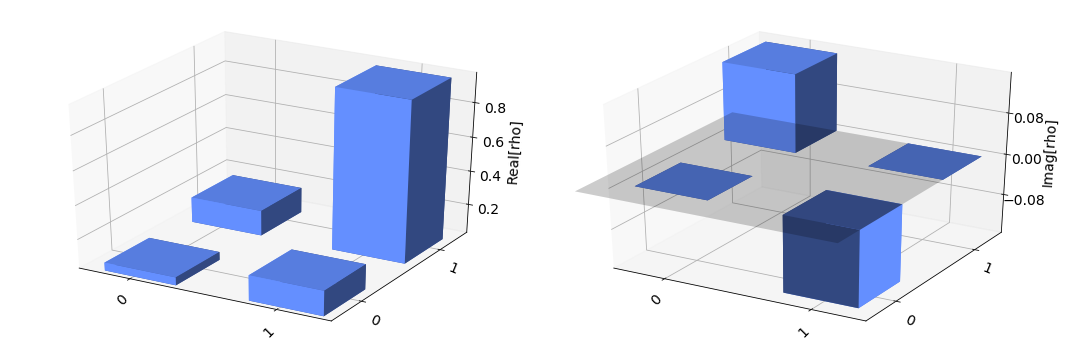

In [5]:
plot_state_city(rho_mle)

# Eigenvalues of the MLE of the density matrix

In [6]:
print(np.diag(np.linalg.eig(rho_mle)[0]))

[[6.771262e-18+1.65163600e-17j 0.000000e+00+0.00000000e+00j]
 [0.000000e+00+0.00000000e+00j 1.000000e+00+2.05528245e-16j]]


# Bayesian mean estimate of the density matrix

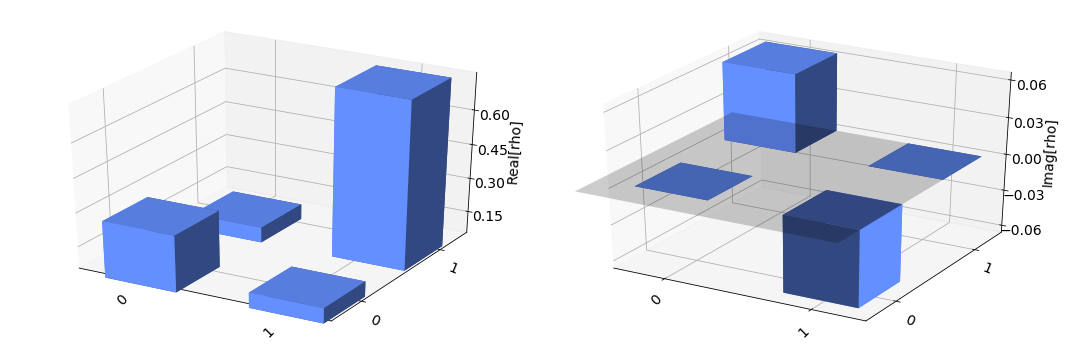

In [7]:
plot_state_city(rho_fit)

# Eigenvalues of the BME of the density matrix

In [8]:
print(np.diag(np.linalg.eig(rho_fit)[0]))

[[0.23692978+0.j 0.        +0.j]
 [0.        +0.j 0.76307022+0.j]]


# Errorbars on observables

[[-1  0]
 [ 0  1]]
(nan+nanj)
(0.9969365834791395+0j)
nan


/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


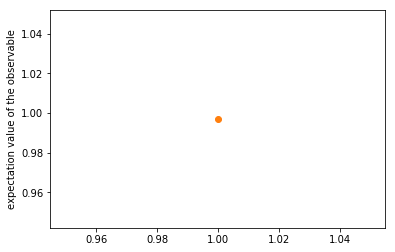

In [11]:
#choose observable
Z = np.array([[-1,0],[0,1]])
print(Z)
ID = np.array([[1,0],[0,1]])

Z3 = np.kron(np.kron(Z, ID),ID)

obs = Z

#compute expectation value
exp_obs_bme = np.trace(np.matmul(obs,rho_fit))
print(exp_obs_bme)

exp_obs_mle = np.trace(np.matmul(obs,rho_mle))
print(exp_obs_mle)

#compute errorbar on expectation value
err_obs_bme = compute_std_error(obs, error_rho)
print(err_obs_bme)

# plot expectation value with errorbar
plt.errorbar(1, exp_obs_bme, yerr=err_obs_bme, fmt='o')
plt.errorbar(1, exp_obs_mle, fmt='o')
# plt.xlim(0,2) 
# plt.ylim(-0.5,1)
plt.ylabel('expectation value of the observable')
plt.show()

## Variable number of trials

In [10]:
rho_mle_vec = []
rho_bme_vec = []
error_bme_vec = []
exp_obs_bme = []
exp_obs_mle = []
err_obs_bme = []

shots_vec = [1,3,5,10,20,50,100,200, 300, 400, 500, 700]

#number of qubits
n = 1

for SHOTS in shots_vec:
    
    #create a qubit register
    q_reg = QuantumRegister(n)
    c_reg = ClassicalRegister(n)

    #create a quantum circuit
    circuit = QuantumCircuit(q_reg)


    #append gates to the quantum circuit
    circuit.x(q_reg[0])

    # print(circuit.qasm())

#     #run the circuit
#     job = qiskit.execute(circuit, BasicAer.get_backend('statevector_simulator'))

#     #get wave function at the end of the circuit
#     psi = job.result().get_statevector(circuit)
#     # print('final state of the circuit',psi)


    # Generate circuits for tomography and run tomography on simulator
#     t = time.time()
    qst = tomo.state_tomography_circuits(circuit, q_reg)
    job = qiskit.execute(qst, BasicAer.get_backend('qasm_simulator'), shots=SHOTS)
    # print('Time taken:', time.time() - t)

    # Extract tomography data so that counts are indexed by measurement configuration
    tomo_counts = tomo.tomography_data(job.result(), qst)

    # Generate fitter data and reconstruct density matrix
    probs, basis_matrix, weights = tomo.fitter_data(tomo_counts)
    # print('tomography results',tomo_counts)

    #bayesian reconstruction of the density matrix and error on observable
    rho_fit, error_rho = bme_fit(probs, basis_matrix, SHOTS)
    rho_bme_vec.append(rho_fit)
    error_bme_vec.append(error_rho)

    #maximum likelihood reconstruction of density matrix
    rho_mle = tomo.state_mle_fit(probs, basis_matrix, weights)
    rho_mle_vec.append(rho_mle)
    
    #choose observable
    Z = np.array([[-1,0],[0,1]])
#     print(Z)
#     ID = np.array([[1,0],[0,1]])

#     Z3 = np.kron(np.kron(Z, ID),ID)

    obs = Z

    #compute expectation value
    exp_obs_bme.append(np.trace(np.matmul(obs,rho_fit)))
#     print(exp_obs_bme)

    exp_obs_mle.append(np.trace(np.matmul(obs,rho_mle)))
#     print(exp_obs_mle)

    #compute errorbar on expectation value
    err_obs_bme.append(compute_std_error(obs, error_rho))
#     print(err_obs_bme)

# print("Density matrix from maximum likelihood estimate:")
# print(rho_mle_vec)

# print("Density matrix from Bayesian mean estimate")
# print(rho_bme_vec)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


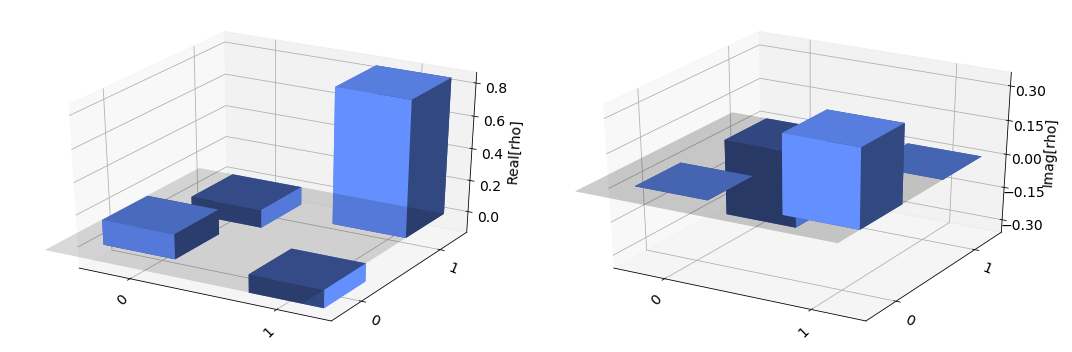

In [38]:
plot_state_city(rho_mle_vec[1])

/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


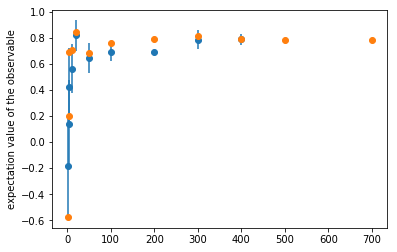

In [71]:
# plot expectation value with errorbar
plt.errorbar(shots_vec, exp_obs_bme, yerr=err_obs_bme, fmt='o')
plt.errorbar(shots_vec, exp_obs_mle, fmt='o')
# plt.xlim(0,2) 
# plt.ylim(-0.5,1)
plt.ylabel('expectation value of the observable')
plt.show()

## Variable number of trials in the presence of read-out noise

/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


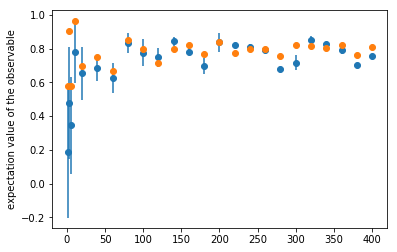

In [96]:
rho_mle_vec = []
rho_bme_vec = []
error_bme_vec = []
exp_obs_bme = []
exp_obs_mle = []
err_obs_bme = []

backend = qiskit.Aer.get_backend('qasm_simulator')

shots_vec = [1,3,5,10,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400]

#number of qubits
n = 1

# Generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(n):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1, 0.9]])
    noise_model.add_readout_error(read_err, [qi])


for SHOTS in shots_vec:
    
    #create a qubit register
    q_reg = QuantumRegister(n)
    c_reg = ClassicalRegister(n)

    #create a quantum circuit
    circuit = QuantumCircuit(q_reg)


    #append gates to the quantum circuit
    circuit.x(q_reg[0])

    # print(circuit.qasm())

    # Generate circuits for tomography and run tomography on simulator
    qst = tomo.state_tomography_circuits(circuit, q_reg)
    qobj = qiskit.compile(qst, backend = backend, shots=SHOTS)
    job = backend.run(qobj, noise_model=noise_model)

    # Extract tomography data so that counts are indexed by measurement configuration
    tomo_counts = tomo.tomography_data(job.result(), qst)

    # Generate fitter data and reconstruct density matrix
    probs, basis_matrix, weights = tomo.fitter_data(tomo_counts)
    # print('tomography results',tomo_counts)

    #bayesian reconstruction of the density matrix and error on observable
    rho_fit, error_rho = bme_fit(probs, basis_matrix, SHOTS)
    rho_bme_vec.append(rho_fit)
    error_bme_vec.append(error_rho)

    #maximum likelihood reconstruction of density matrix
    rho_mle = tomo.state_mle_fit(probs, basis_matrix, weights)
    rho_mle_vec.append(rho_mle)
    
    #choose observable
    Z = np.array([[-1,0],[0,1]])
    ID = np.array([[1,0],[0,1]])

    Z2 = np.kron(ID, Z)
    obs = Z

    #compute expectation value
    exp_obs_bme.append(np.trace(np.matmul(obs,rho_fit)))
#     print(exp_obs_bme)

    exp_obs_mle.append(np.trace(np.matmul(obs,rho_mle)))
#     print(exp_obs_mle)

    #compute errorbar on expectation value
    err_obs_bme.append(compute_std_error(obs, error_rho))
#     print(err_obs_bme)


# plot expectation value with errorbar
plt.errorbar(shots_vec, exp_obs_bme, yerr=err_obs_bme, fmt='o')
plt.errorbar(shots_vec, exp_obs_mle, fmt='o')
plt.ylabel('expectation value of the observable')
plt.show()